# COCOデータセット

## アノテーションデータの確認とSegmentation画像作成

In [1]:
%matplotlib inline
import copy

import numpy as np
import pickle
import glob
import cv2
from tqdm import tqdm
from PIL import Image
import matplotlib.pyplot as plt
from pycocotools.coco import COCO

In [2]:
# Semgentation画像の色の設定の呼び出し
f = open('./coco_dataset_2014/t_color.txt',"rb")
t_color = pickle.load(f)
f = open('./coco_dataset_2014/t_class_name.txt',"rb")
t_color_name = pickle.load(f)

In [3]:
data_dir = './coco_dataset_2014/'
# resizeした画像は'./coco_dataset_2014/resize_224/'に格納

# 元の学習データ
# train
data_train_dir = data_dir + 'train2014/'
# test
data_val_dir = data_dir + 'val2014/'

# 正解Semantic Segmenation
# train
seg_train_dir = data_dir + 'semantic_train/'
# test
seg_val_dir = data_dir + 'semantic_val/'

# 正解Instance Segmenation
# train
ins_train_dir = data_dir + 'instance_train/'
# test
ins_val_dir = data_dir + 'instace_val/'

In [10]:
# COCOアノテーションデータ
dataDir ='./coco'
dataType='val2014'
annFile='%s/annotations/instances_%s.json'%(dataDir,dataType)

In [11]:
# initialize COCO api for instance annotations
coco=COCO(annFile)
# display COCO categories and supercategories
cats = coco.loadCats(coco.getCatIds())
name=[cat['name'] for cat in cats]
print(len(name))
print('COCO categories: \n\n', ' '.join(name))

nms = set([cat['supercategory'] for cat in cats])
print('COCO supercategories: \n', ' '.join(nms))

loading annotations into memory...
Done (t=4.21s)
creating index...
index created!
80
COCO categories: 

 person bicycle car motorcycle airplane bus train truck boat traffic light fire hydrant stop sign parking meter bench bird cat dog horse sheep cow elephant bear zebra giraffe backpack umbrella handbag tie suitcase frisbee skis snowboard sports ball kite baseball bat baseball glove skateboard surfboard tennis racket bottle wine glass cup fork knife spoon bowl banana apple sandwich orange broccoli carrot hot dog pizza donut cake chair couch potted plant bed dining table toilet tv laptop mouse remote keyboard cell phone microwave oven toaster sink refrigerator book clock vase scissors teddy bear hair drier toothbrush
COCO supercategories: 
 sports electronic animal appliance kitchen accessory indoor person furniture outdoor vehicle food


### アノテーション画像の確認

In [70]:
# get all images containing given categories, select one at random
catIds = coco.getCatIds(catNms=['person'])
imgIds = coco.getImgIds(catIds=catIds);
img = coco.loadImgs(imgIds[np.random.randint(0,len(imgIds))])[0]

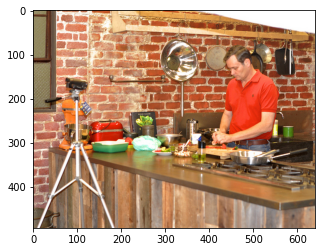

In [71]:
# load and display image
I = Image.open(data_train_dir + img['file_name'])
plt.figure()
plt.imshow(I)

In [72]:
img

{'license': 3,
 'file_name': 'COCO_train2014_000000048863.jpg',
 'coco_url': 'http://mscoco.org/images/48863',
 'height': 494,
 'width': 640,
 'date_captured': '2013-11-14 18:28:17',
 'flickr_url': 'http://farm3.staticflickr.com/2839/8979322702_6c23642700_z.jpg',
 'id': 48863}

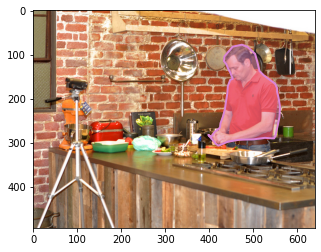

In [73]:
# personクラスが囲われている.
plt.imshow(I)
annIds = coco.getAnnIds(imgIds=img['id'], catIds=catIds, iscrowd=None)
anns = coco.loadAnns(annIds)
coco.showAnns(anns)

In [14]:
# get all images containing given categories, select one at random
catIds = coco.getCatIds(catNms=['tie'])
imgIds = coco.getImgIds(catIds=catIds);
img = coco.loadImgs(imgIds[np.random.randint(0,len(imgIds))])[0]

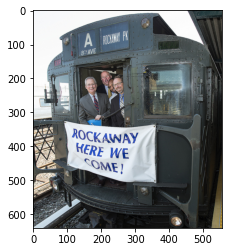

In [16]:
# load and display image
I = Image.open(data_val_dir + img['file_name'])
plt.figure()
plt.imshow(I)

In [17]:
img

{'license': 4,
 'file_name': 'COCO_val2014_000000550980.jpg',
 'coco_url': 'http://mscoco.org/images/550980',
 'height': 640,
 'width': 555,
 'date_captured': '2013-11-17 09:38:29',
 'flickr_url': 'http://farm9.staticflickr.com/8271/8894929127_0b3cc88650_z.jpg',
 'id': 550980}

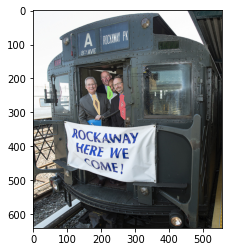

In [18]:
# personクラスが囲われている.
plt.imshow(I)
annIds = coco.getAnnIds(imgIds=img['id'], catIds=catIds, iscrowd=None)
anns = coco.loadAnns(annIds)
coco.showAnns(anns)

In [82]:
# segmentation画像作成
img_seg = np.zeros((img['height'],img['width'], 3), dtype=int)
img_ins = np.zeros((img['height'],img['width'], 3), dtype=int)
pre_color = []
for i in range(len(t_color_name)-1):
    catIds = coco.getCatIds(catNms=[t_color_name[i]])
    annIds = coco.getAnnIds(imgIds=img["id"], catIds=catIds, iscrowd=False)
    if not annIds:
        continue

    anns = coco.loadAnns(annIds)
    for ann in anns:
        # Instanceの色を作成
        while(True):
            color = np.random.randint(1, 255, 3)
            if not [j for j in range(len(pre_color))
                    if np.sum(pre_color[j] == color) == 3]:
                pre_color.append(color)
                break

        mask = coco.annToMask(ann)
        mask = np.array(mask, dtype=int)
        mask_seg = mask[..., None] * t_color[i]
        mask_ins = mask[..., None] * color

        img_seg = np.where(img_seg == 0, mask_seg, img_seg)
        img_ins = np.where(img_ins == 0, mask_ins, img_ins)

image_seg = copy.deepcopy(img_seg)
image_seg[:, :, 0] = img_seg[:, :, 2]
image_seg[:, :, 2] = img_seg[:, :, 0]
image_ins = copy.deepcopy(img_ins)
image_ins[:, :, 0] = img_ins[:, :, 2]
image_ins[:, :, 2] = img_ins[:, :, 0]

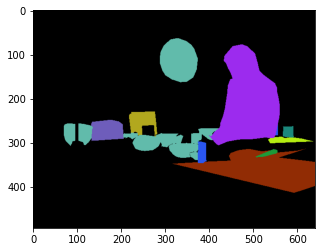

In [83]:
# semantic segmentation
plt.imshow(img_seg)
#表示
plt.show()

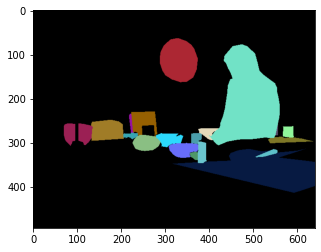

In [84]:
# instance segmentation
plt.imshow(img_ins)
#表示
plt.show()

### 正解Segmentation画像作成

In [7]:
# 以下はtrainデータの場合.
# valデータも同様にSegmentation画像を作成する.
data_name = sorted(glob.glob(data_train_dir + "*"))
for img_name in tqdm(data_name):
    # segmentation画像作成
    # train
    id_ = int(img_name.split("/")[-1][19:25])
    # val
    #id_ = int(img_name.split("/")[-1][21:27])
    img = coco.loadImgs(id_)[0]
    img_seg = np.zeros((img['height'],img['width'], 3), dtype=int)
    img_ins = np.zeros((img['height'],img['width'], 3), dtype=int)
    pre_color = []
    for i in range(len(t_color_name)-1):
        catIds = coco.getCatIds(catNms=[t_color_name[i]])
        annIds = coco.getAnnIds(imgIds=id_, catIds=catIds, iscrowd=False)
        if not annIds:
            continue

        anns = coco.loadAnns(annIds)
        for ann in anns:
            # Instanceの色を作成
            while(True):
                color = np.random.randint(1, 255, 3)
                if not [j for j in range(len(pre_color))
                        if np.sum(pre_color[j] == color) == 3]:
                    pre_color.append(color)
                    break

            mask = coco.annToMask(ann)
            mask = np.array(mask, dtype=int)
            mask_seg = mask[..., None] * t_color[i]
            mask_ins = mask[..., None] * color

            img_seg = np.where(img_seg == 0, mask_seg, img_seg)
            img_ins = np.where(img_ins == 0, mask_ins, img_ins)
            
    image_seg = copy.deepcopy(img_seg)
    image_seg[:, :, 0] = img_seg[:, :, 2]
    image_seg[:, :, 2] = img_seg[:, :, 0]
    image_ins = copy.deepcopy(img_ins)
    image_ins[:, :, 0] = img_ins[:, :, 2]
    image_ins[:, :, 2] = img_ins[:, :, 0]

    cv2.imwrite(seg_train_dir + img_name.split("/")[-1][:-4] + '.png', image_seg)
    cv2.imwrite(ins_train_dir + img_name.split("/")[-1][:-4] + '.png', image_ins)


100%|██████████| 82783/82783 [3:04:49<00:00,  7.47it/s]  


### 画像のcrop, resize

In [167]:
# resize用
dir__img = sorted(glob.glob(data_train_dir + "*"))
dir__seg = sorted(glob.glob(seg_train_dir + "*"))
dir__ins = sorted(glob.glob(ins_train_dir + "*"))

size_ = 224
for i in tqdm(range(len(dir__img))):
    a = Image.open(dir__img[i])
    b = Image.open(dir__seg[i])
    c = Image.open(dir__ins[i])
    if a.size[0]>a.size[1]:
        mal = size_/a.size[1]
        a = a.resize((int(a.width * mal), int(a.height * mal)))
        b = b.resize(a.size)
        c = c.resize(a.size)
        y_size = a.size[0]
        a = a.crop((int(y_size/2-size_/2), 0, int(y_size/2+size_/2), size_))
        b = b.crop((int(y_size/2-size_/2), 0, int(y_size/2+size_/2), size_))
        c = c.crop((int(y_size/2-size_/2), 0, int(y_size/2+size_/2), size_))
    else:
        mal = size_/a.size[0]
        a = a.resize((int(a.width * mal), int(a.height * mal)))
        b = b.resize(a.size)
        c = c.resize(a.size)
        x_size = a.size[1]
        a = a.crop((0, int(x_size/2-size_/2), size_, int(x_size/2+size_/2)))
        b = b.crop((0, int(x_size/2-size_/2), size_, int(x_size/2+size_/2)))
        c = c.crop((0, int(x_size/2-size_/2), size_, int(x_size/2+size_/2)))
        
    a = a.resize((size_, size_))
    b = b.resize((size_, size_))
    c = c.resize((size_, size_))
    
    a.save(data_dir + "resize_224/val2014/" + dir__img[i].split("/")[-1])
    b.save(data_dir + "resize_224/semantic_val/" + dir__seg[i].split("/")[-1])
    c.save(data_dir + "resize_224/instance_val/" + dir__ins[i].split("/")[-1])

100%|██████████| 40504/40504 [10:19<00:00, 65.41it/s]


### 標準化用計算

##### 学習/評価の標準化に用いる学習データの平均と標準偏差を予め計算しておく.

In [43]:
dir__img = sorted(glob.glob("./coco_dataset_2014/resize_224/train2014/*"))
sum_ = [0, 0, 0]
for i in tqdm(range(len(dir__img))):
    aaa = np.array(Image.open(dir__img[i]))
    if len(aaa.shape) != 3:
        aaa = np.tile(aaa[:, :, None], (1, 1, 3))
    if aaa.shape[2] == 4:
        aaa = aaa[:, :, :3]
    aaa = np.sum(np.sum(aaa, axis=0), axis=0)
    sum_ += aaa
sum_ = sum_ / (len(dir__img)*(224*224)*225)

100%|██████████| 82783/82783 [01:39<00:00, 830.97it/s] 


In [28]:
# 平均
sum_

array([0.47718249, 0.45077697, 0.41083121])

In [44]:
dir__img = sorted(glob.glob("./coco_dataset_2014/resize_224/train2014/*"))
std = [0, 0, 0]
for i in tqdm(range(len(dir__img))):
    aaa = np.array(Image.open(dir__img[i]))/255
    if len(aaa.shape) != 3:
        aaa = np.tile(aaa[:, :, None], (1, 1, 3))
    if aaa.shape[2] == 4:
        aaa = aaa[:, :, :3]
    aaa = (aaa-sum_)**2
    aaa = np.sum(np.sum(aaa, axis=0), axis=0)
    std += aaa
std = std / (len(dir__img)*(224*224))
std = np.sqrt(std)

100%|██████████| 82783/82783 [02:49<00:00, 489.68it/s]


In [46]:
# 標準偏差
np.sqrt(std)

array([0.28440453, 0.27957511, 0.29210849])